In [127]:
%matplotlib inline
from PIL import Image, ImageFont, ImageDraw, ImageEnhance
from itertools import repeat
import os
import tensorflow as tf
import time
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import RMSprop
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import model_from_json
import keras.callbacks as cb
import matplotlib.pyplot as plt

In [3]:

def loadModel(modelName, paramName):
    # load json and create model
    json_file = open(modelName, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(paramName)
    print("Loaded model from disk")
    return loaded_model

In [4]:
def loadImage(imgFd):
    """
    Return an array that contains {imageArray, topPixelPos, leftPixelPos}
    """
    new_width=64
    new_height=128
    channel=3
    result=[]
    posInfo=[]
    
    width, height = imgFd.size   # Get dimensions
    width=width-new_width
    height=height-new_height
    #select top left from available range
    curWidth=0
    curHeight=0
    while(curWidth<width):
        curHeight=0
        while(curHeight<height):
            #print(curWidth, curHeight)
            top=curHeight
            left=curWidth
            im=imgFd.crop((left, top, left+new_width, top+new_height))
            im=np.asarray(im)
            _,_,z=im.shape
            if(z==4):
                im=np.delete(im,3,axis=2)
            #im=im.reshape(new_width*new_height*3)
            result.append(im)
            posInfo.append([top,left])
            #move height 32 pixel a time
            curHeight+=32
        curWidth+=16

    return np.array(result), np.array(posInfo)

In [260]:
def processImg(drc, imgName):
    """
    Return a filePath and List that contains {imgArray, scaleRatio}
    """
    train_dir = drc
    inputFile=imgName
    inputFile=os.path.join(train_dir, inputFile)
    print("Input image is stored at:",inputFile)
    im=Image.open(inputFile, 'r')
    scaleRatio=1
    step=1.5
    baseWidth,baseHeight=im.size
    curWidth,curHeight=im.size
    imgList=[]
    while(curHeight>128 and curWidth>64):
        scaleRatio=scaleRatio*step
        img = im.resize((int(baseWidth/scaleRatio),int(baseHeight/scaleRatio)), Image.ANTIALIAS)
        curHeight=img.size[1]
        curWidth=img.size[0]
    #backtrace
    scaleRatio=scaleRatio/step
    img = im.resize((int(baseWidth/scaleRatio),int(baseHeight/scaleRatio),), Image.ANTIALIAS)
    #scaleRatio=scaleRatio/step
    img2= im.resize((int(baseWidth/scaleRatio*step),int(baseHeight/scaleRatio*step),), Image.ANTIALIAS)
    # scaleRatio=scaleRatio/step
    # img3= im.resize((int(baseWidth/scaleRatio),int(baseHeight/scaleRatio),), Image.ANTIALIAS)
    imgArr,posArr=loadImage(img)
    imgList.append([imgArr,posArr, scaleRatio])
    imgArr,posArr=loadImage(img2)
    imgList.append([imgArr,posArr, scaleRatio/step])
    # imgList.append(loadImage(img3))
    return inputFile,imgList


In [261]:
def detectPic(lst, modelLST):
    """
    Return the scale of image being detected, and top, left pexil position of rectangle
    """
    for trio in lst:
        item=trio[0]
        posInfo=trio[1]
        scale=trio[2]
        ans=modelLST[0].predict_classes(item)
        ans2=modelLST[1].predict_classes(item)
        ans3=modelLST[2].predict_classes(item)
        vote=np.add(ans,ans2)
        vote=np.add(vote,ans3)
        if(np.amax(vote)==3):
            pos=np.argmax(vote)
            print("Good Confidence")
            print("ScaleRatio:", scale)
            print("pixelPos:", posInfo[pos])
#             return [scale, posInfo[pos],item[pos]]
            return [scale, posInfo[pos][0],posInfo[pos][1], item[pos]]
        else:
            vote=(vote/2).astype(int)
            if(np.amax(vote)==1):
                pos=np.argmax(ans)
                print("Average Confidence")
                print("ScaleRatio:", scale)
                print("pixelPos:", posInfo[pos])
#                 return [scale, posInfo[pos],item[pos]]
                return [scale, posInfo[pos][0],posInfo[pos][1], item[pos]]
    return False

In [262]:
def outputImg(filePath,scale, top, left):
    width=64
    height=128
    fileFd=Image.open(filePath,'r')
    draw = ImageDraw.Draw(fileFd)
    top=int(top*scale)
    left=int(left*scale)
    bottom=top+int(height*scale)
    right=left+int(width*scale)
    draw.line((left,top, left,bottom), fill=128, width=20)
    draw.line((left,top, right,top), fill=128, width=20)
    draw.line((left,bottom, right,bottom), fill=128, width=20)
    draw.line((right,top, right,bottom), fill=128, width=20)
    outPath=filePath[:-4]+'out.jpg'
    fileFd.save(outPath)
    print('Detected Image is saved at original location!')
    return fileFd

In [263]:
drc='./'
modelName='modelD.json'
paramName='modelD.h5'
modelName2='modelD2.json'
paramName2='modelD2.h5'
modelName3='modelD3.json'
paramName3='modelD3.h5'
modelName=os.path.join(drc, modelName)
paramName=os.path.join(drc, paramName)
loaded_model=loadModel(modelName, paramName)
loaded_model2=loadModel(modelName2, paramName2)
loaded_model3=loadModel(modelName3, paramName3)
loaded_model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
loaded_model2.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
loaded_model3.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
modelList=[loaded_model, loaded_model2, loaded_model3]

Loaded model from disk
Loaded model from disk
Loaded model from disk


Input image is stored at: ./App/3.jpg
Average Confidence
ScaleRatio: 17.0859375
pixelPos: [32 64]
Detected Image is saved at original location!


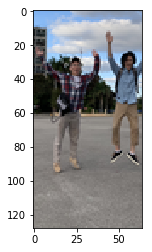

In [278]:
im,imgList=processImg('./App', '3.jpg')
quad=detectPic(imgList, modelList)
if(type(quad)!=type(False)):
    #human detected
    img=outputImg(im,quad[0], quad[1],quad[2])
    plt.imshow(quad[3])
else:
    print ("There is no Human in this Picture!")

In [275]:
a

[1, 2, 3, 4, 5, 6, 7, 8]